In [ ]:
# Install required libs
%pip install -U segmentation_models_pytorch albumentations --user --quiet

In [1]:
# Install required libs
%pip install -U albumentations --user --quiet

Note: you may need to restart the kernel to use updated packages.


# Loading data

In [83]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive, files
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')

In [85]:
#DATA_DIR = '/content/data_colab/food'
DATA_DIR = './data_colab/food/'

#if not os.path.exists(DATA_DIR):
#files.upload()

In [86]:
if not os.path.exists(DATA_DIR):
  !unzip /content/drive/MyDrive/Be.ai/data_colab.zip # to /content/data

In [87]:
x_train_dir = os.path.join(DATA_DIR, 'train/img')
y_train_dir = os.path.join(DATA_DIR, 'train/masks_machine')
y_train_human_dir = os.path.join(DATA_DIR, 'train/masks_human')


x_valid_dir = os.path.join(DATA_DIR, 'valid/img')
y_valid_dir = os.path.join(DATA_DIR, 'valid/masks_machine')
y_valid_human_dir = os.path.join(DATA_DIR, 'valid/masks_human')

x_test_dir = os.path.join(DATA_DIR, 'test/img')
y_test_dir = os.path.join(DATA_DIR, 'test/masks_machine')
y_test_human_dir = os.path.join(DATA_DIR, 'test/masks_human')

In [92]:
# helper function for data visualization
import matplotlib.pyplot as plt
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [106]:
image = cv2.imread('./data_colab/food/train/img/3c8d37a5-f683-4ee9-aacf-1cf916060c5f.jpg', cv2.IMREAD_COLOR)
mask = cv2.imread('./data_colab/food/train/masks_machine/3c8d37a5-f683-4ee9-aacf-1cf916060c5f.png', cv2.IMREAD_UNCHANGED)
human_mask = cv2.imread('./data_colab/food/train/masks_human/3c8d37a5-f683-4ee9-aacf-1cf916060c5f.png', cv2.IMREAD_COLOR)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
human_mask = cv2.cvtColor(human_mask, cv2.COLOR_BGR2RGB)

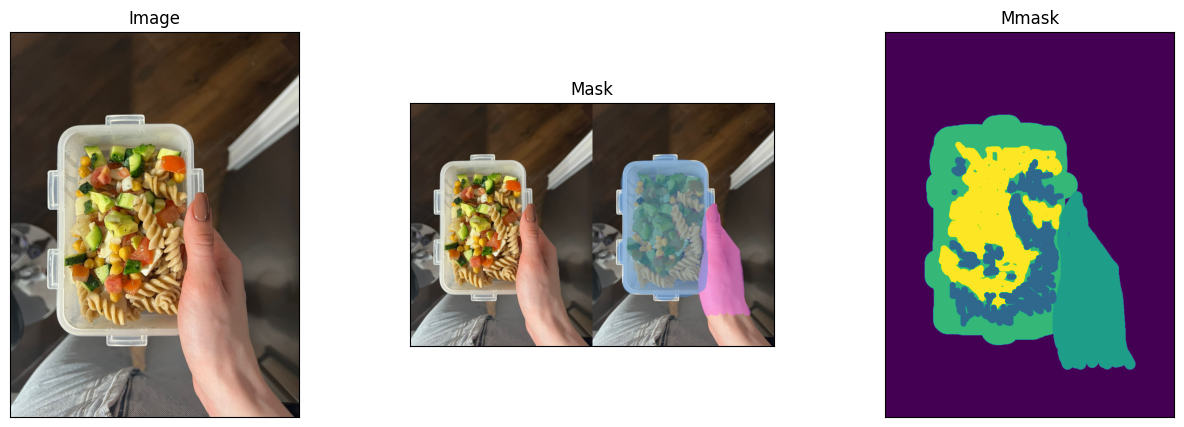

In [107]:
visualize(image=image,mask=human_mask, mmask=mask)

In [99]:
mask.shape

(1600, 1200)

# Dataloader

In [108]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [167]:
class Dataset(BaseDataset):
    """Food Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['proteins', 'cellulose', 'carbohydrates', 'plate', 'palm',
               'container', 'fats', 'soup', 'salad', 'unlabelled']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        # we need this crutch for .ds_store files
        self.ids = [i for i in self.ids if self.get_file_extension(images_dir, i,) == '.jpg']
        self.mask_ids = [self.get_mask_name(images_dir, i, ".png") for i in self.ids if self.get_file_extension(images_dir, i,) == '.jpg']
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.mask_ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_img = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask_img == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)


    def get_mask_name(self, img_path, img, file_extension = ".png"):
      mask_filename = os.path.splitext(os.path.basename(os.path.join(img_path, img)))[0]
      mask = mask_filename.join(["", file_extension])
      return mask

    def get_file_extension(self, img_path, img):
      if os.path.splitext(os.path.basename(os.path.join(img_path, img)))[1]:
            return os.path.splitext(os.path.basename(os.path.join(img_path, img)))[1]
      return ''


float64
(1600, 1200, 10)


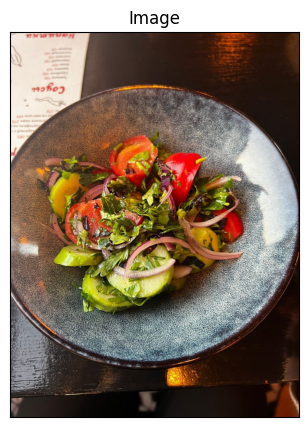

In [168]:
# Lets look at data we have
CLASSES = ['proteins', 'cellulose', 'carbohydrates', 'plate', 'palm',
               'container', 'fats', 'soup', 'salad', 'unlabelled']

dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES)

image, mask = dataset[4] # get some sample

print(mask.dtype)
print(mask.shape)
visualize(
    image=image,
)

# Augmentations

In [163]:
import albumentations as albu

In [209]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0, value=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                # albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(1600, 1216)
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    img_size = 512
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.LongestMaxSize(img_size),          # unify size
        albu.Normalize(),                       # normalize
        albu.PadIfNeeded(img_size, img_size),   # W = H
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

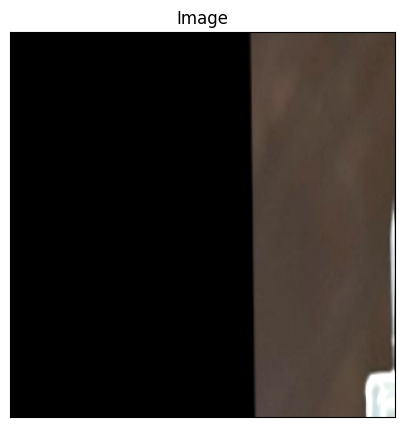

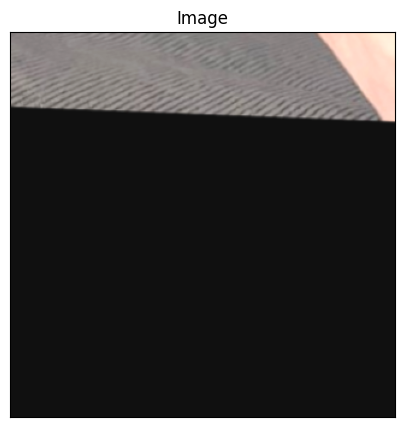

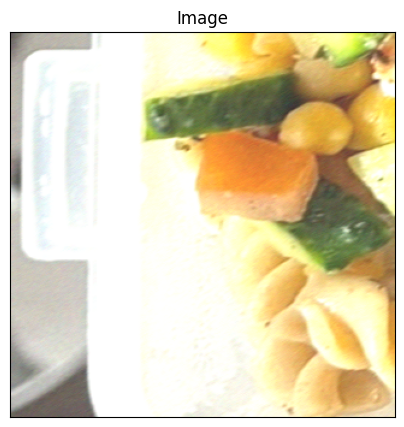

In [210]:

#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=CLASSES,
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image) #, mask=mask.squeeze(-1))

# Create model and train

In [211]:
%pip install -U segmentation-models-pytorch --quiet


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [212]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [213]:
ENCODER = 'timm-mobilenetv3_large_100' #'resnet50'  #'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = CLASSES
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' #'mps'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [214]:
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True) #, num_workers=1) #num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False) #, num_workers=1) #num_workers=4)

In [215]:
from segmentation_models_pytorch import utils
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

#loss = smp.losses.DiceLoss(mode='multiclass')
loss = utils.losses.BCELoss()

metrics = [
  utils.metrics.IoU(threshold=0.2),
  utils.metrics.Fscore(),
  utils.metrics.Recall(),
  utils.metrics.Precision(),
]

optimizer = torch.optim.Adam([
  dict(params=model.parameters(), lr=0.0001),
])

In [216]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [217]:
# train model for 40 epochs

max_score = 0

for i in range(0, 10): #range(0, 40):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:  24%|██▍       | 6/25 [00:45<02:20,  7.40s/it, bce_loss - 0.8643, iou_score - 0.0867, fscore - 0.1258, recall - 0.2691, precision - 0.08228] 

# Test best saved model

In [190]:
import torch
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [191]:
# create test dataset
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [192]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid:  97%|█████████▋| 92/95 [02:00<00:03,  1.31s/it, bce_loss - 0.1265, iou_score - 0.5828, fscore - 0.7607, recall - 0.7152, precision - 0.8166]


RuntimeError: Wrong input shape height=4032, width=3024. Expected image height and width divisible by 32. Consider pad your images to shape (4032, 3040).

# Visualize predictions

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir,
    classes=CLASSES,
)

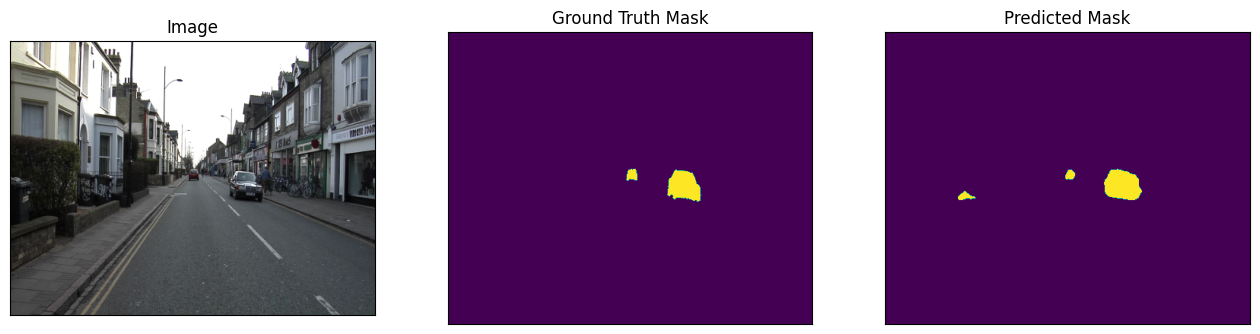

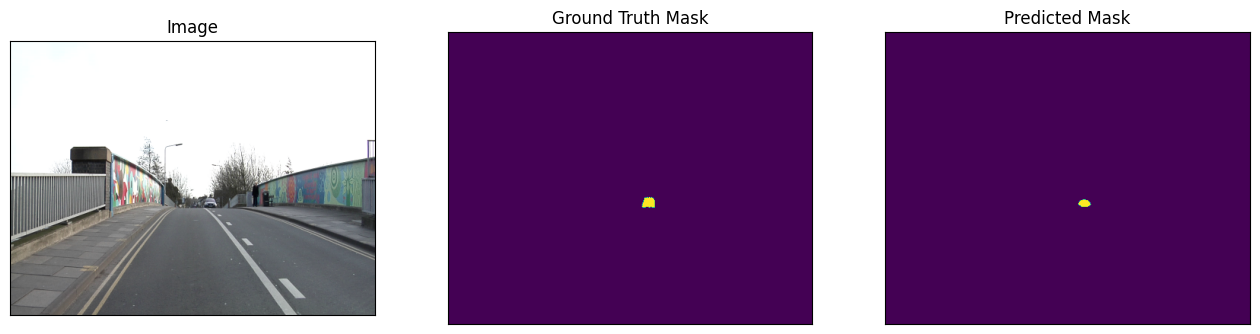

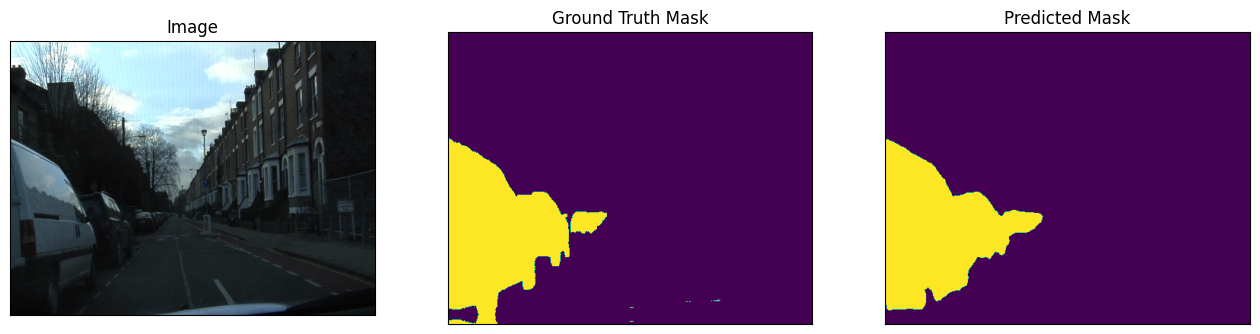

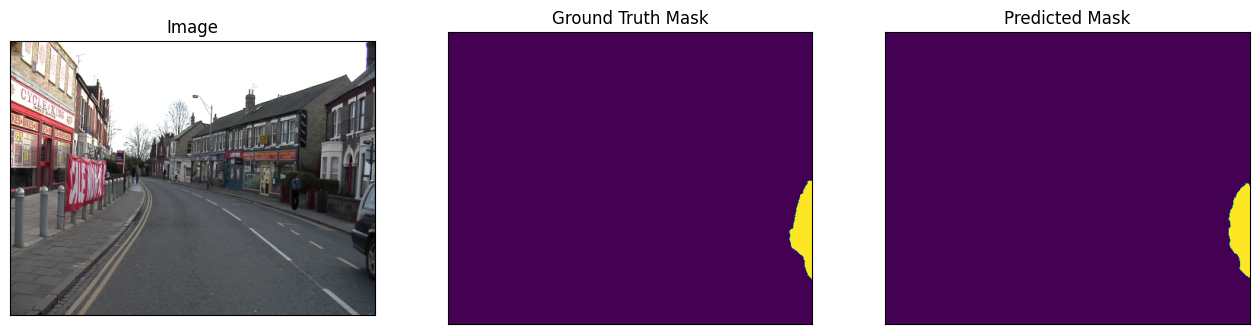

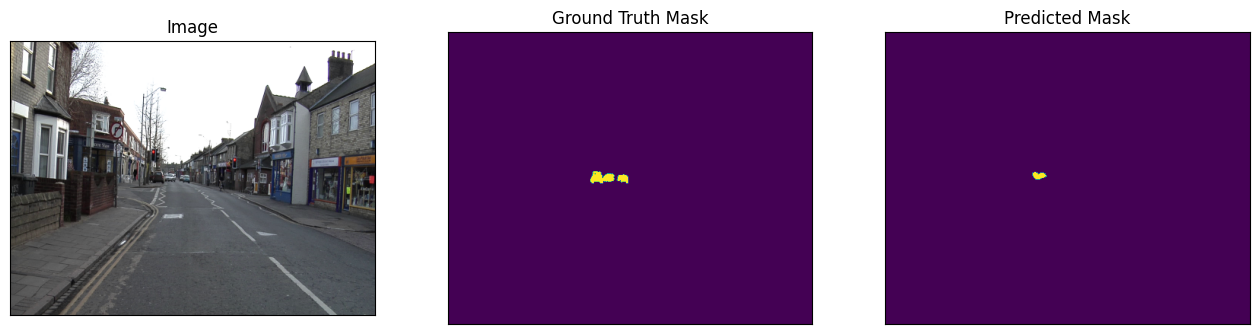

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))

    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize(
        image=image_vis,
        #ground_truth_mask=gt_mask, # нужно научиться представлять это все в виде нормальной маски, а не тензора W * H * 10
        #predicted_mask=pr_mask
    )